In [1]:
%load_ext autoreload
%autoreload 2
import os;
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.vaep.formula as vaepformula

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
## Configure file and folder names
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder,"atomic-spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions-one-action.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
print("nb of games:", len(games))

nb of games: 64


In [4]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"atomic_actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(bodyparts,how="left")
        .merge(players,how="left")
        .merge(teams,how="left",)
        .sort_values(["game_id","period_id","action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaepformula.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|██████████| 64/64 [00:03<00:00, 19.17it/s]


Index(['game_id', 'period_id', 'action_id', 'time_seconds', 'timestamp',
       'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id', 'bodypart_id',
       'type_name', 'bodypart_name', 'player_name', 'player_nickname',
       'jersey_number', 'country_id', 'country_name', 'extra', 'team_name',
       'scores', 'concedes', 'offensive_value', 'defensive_value',
       'vaep_value'],
      dtype='object')

In [5]:
# Use this if you want to assign credit for the receival back to the initial passer
# A["player_id"] = A.player_id.mask(A.type_name == "receival", A.player_id.shift(1))

### Most valuable players

In [6]:
A["count"] = 1

playersR = (
    A[["player_id","vaep_value","offensive_value","defensive_value","count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
playersR = playersR.merge(players[["player_id","player_nickname","player_name"]],how="left")
playersR["player"] = playersR[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
playersR = playersR[["player_id","player","vaep_value","offensive_value","defensive_value","count"]]
playersR.sort_values("vaep_value",ascending=False)[:10]

,player_id,player,vaep_value,offensive_value,defensive_value,count
6,3009.0,Kylian Mbappé,5.174053,4.865477,0.308576,721
44,3289.0,Romelu Lukaku,5.161483,5.068484,0.092999,400
172,5207.0,Cristiano Ronaldo,4.669982,4.161479,0.508502,464
92,3621.0,Eden Hazard,4.527920,4.379141,0.148778,1035
122,4320.0,Neymar,4.223929,4.237468,-0.013538,1118
265,5487.0,Antoine Griezmann,3.952715,3.542706,0.410009,813
36,3244.0,John Stones,3.849926,2.542672,1.307254,1454
161,5195.0,Artem Dzyuba,3.826756,3.538541,0.288214,422
209,5246.0,Luis Suárez,3.815417,3.644824,0.170594,518
248,5470.0,Ivan Rakitić,3.799933,3.785021,0.014911,1295


In [7]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5,"player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id","minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
#stats[stats.offensive_rating > 0.1]
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating
34,3237.0,Sergio Agüero,2.609312,2.551902,0.057410,210,193,1.216778,1.190006
75,3531.0,Mohamed Salah,2.413151,2.361189,0.051962,181,189,1.149120,1.124376
172,5207.0,Cristiano Ronaldo,4.669982,4.161479,0.508502,464,381,1.103145,0.983027
251,5473.0,Ahmed Musa,2.631461,2.045054,0.586407,244,220,1.076507,0.836613
117,4269.0,Aleksandar Mitrović,3.168014,3.042223,0.125792,280,271,1.052108,1.010332
161,5195.0,Artem Dzyuba,3.826756,3.538541,0.288214,422,339,1.015953,0.939436
164,5198.0,Diego Costa,3.453443,3.402320,0.051123,271,315,0.986698,0.972091
44,3289.0,Romelu Lukaku,5.161483,5.068484,0.092999,400,488,0.951913,0.934761
152,5186.0,Denis Cheryshev,3.201184,4.081961,-0.880777,332,312,0.923418,1.177489
29,3196.0,Wahbi Khazri,2.699346,2.464484,0.234862,286,264,0.920232,0.840165


### (optional) inspect Belgium's top 10 most valuable non-shot actions

2018-07-14 Belgium 2-0 England 3' receival 3176.0


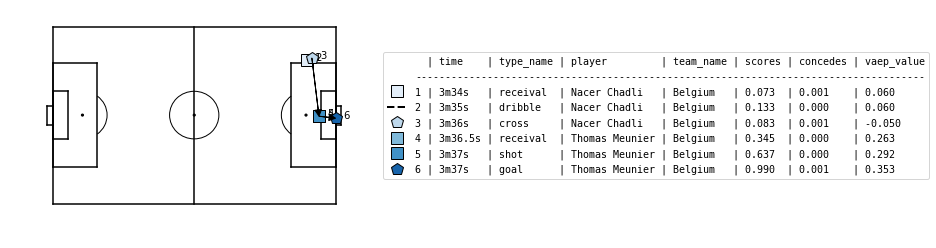

2018-06-28 England 0-1 Belgium 9' dribble 3457.0


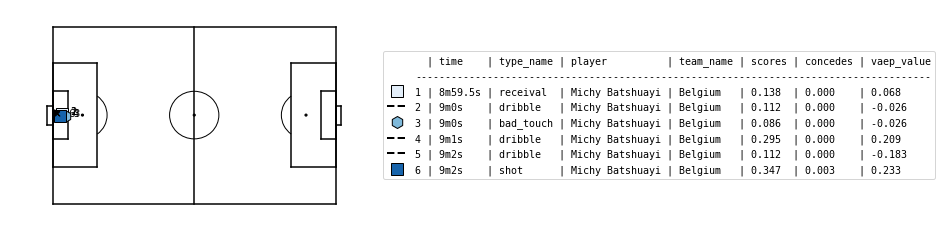

2018-06-23 Belgium 5-2 Tunisia 50' dribble 3621.0


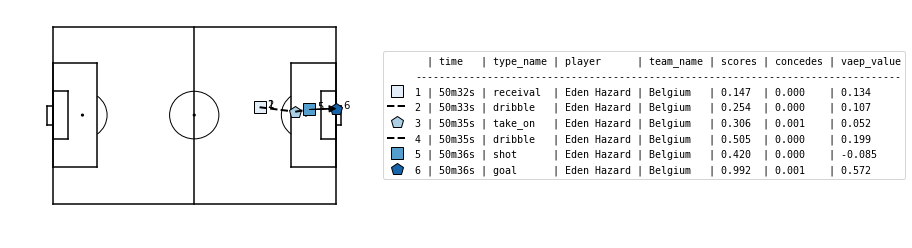

2018-07-02 Belgium 3-2 Japan 93' receival 4831.0


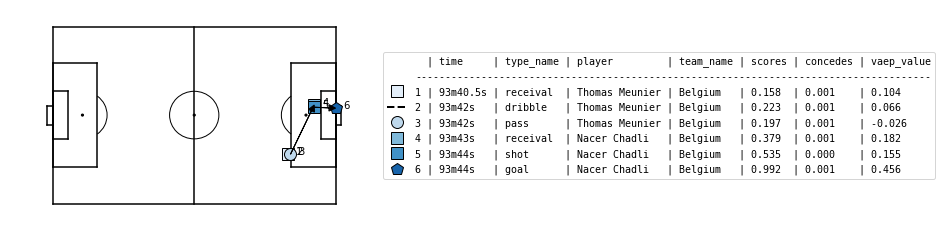

2018-07-02 Belgium 3-2 Japan 73' receival 3296.0


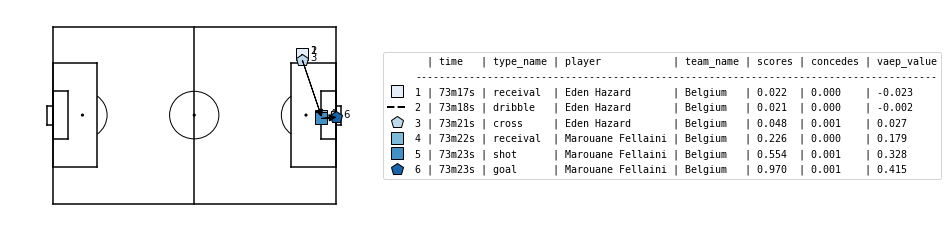

2018-06-28 England 0-1 Belgium 35' receival 5639.0


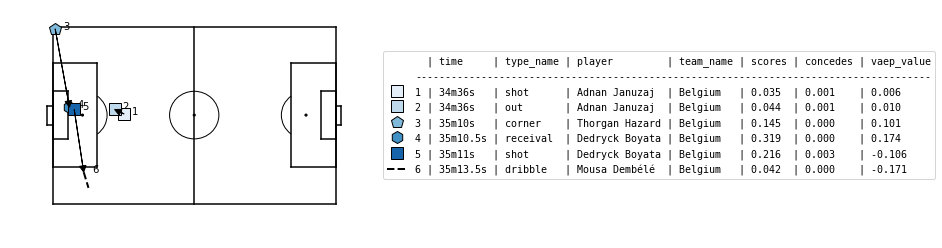

2018-07-02 Belgium 3-2 Japan 48' dribble 3621.0


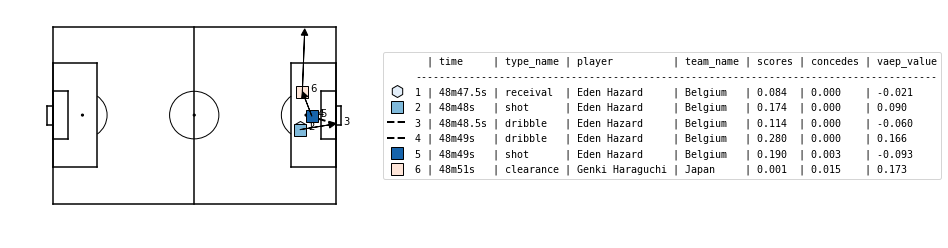

2018-06-23 Belgium 5-2 Tunisia 47' receival 3289.0


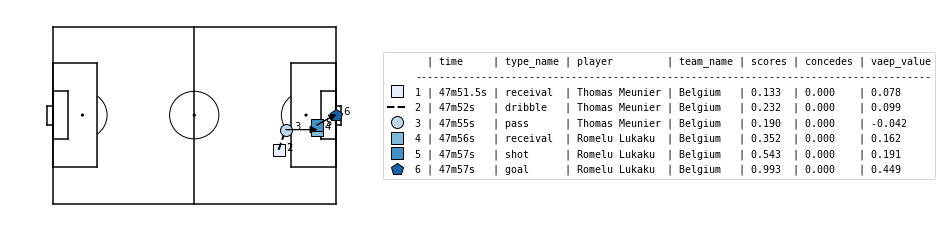

2018-07-02 Belgium 3-2 Japan 53' receival 5642.0


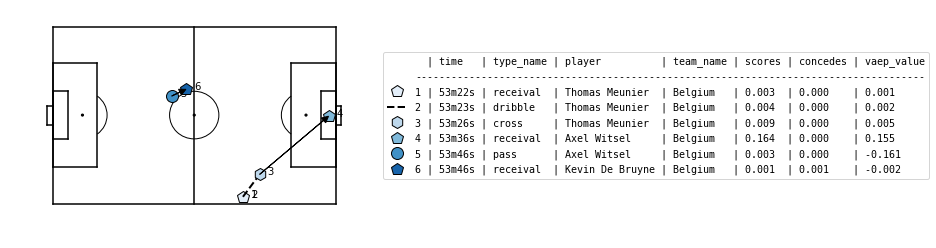

2018-07-02 Belgium 3-2 Japan 61' receival 3289.0


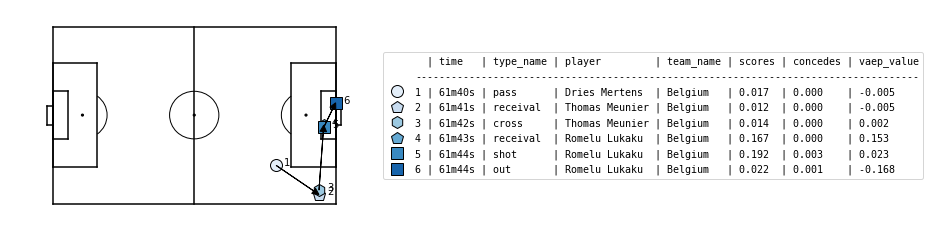

In [9]:
import matplotsoccer

sorted_A = A.sort_values("offensive_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Belgium"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.isin(["goal","shot","shot_penalty"])] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0,10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+3].copy()
    
    a["player"] = a[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_id}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time","type_name","player","team_name","scores","concedes","vaep_value"]
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy
    matplotsoccer.actions(a[["x","y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                label=a[cols],
                labeltitle = cols,
                zoom=False)